# 1. Load data

In [1]:
import numpy as np
import pandas as pd
import random
import itertools
import time
import operator
from operator import itemgetter
import math
import scipy.stats as ss
import pprint as pp

In [2]:
CAB10_flow_df = pd.read_csv('~/SoftComputing/20220202_SC_CAB10_flow.csv', header=None, sep=';')
CAB10_cost_df = pd.read_csv('~/SoftComputing/20220202_SC_CAB10_cost.csv', header=None, sep=';')
CAB25_flow_df = pd.read_csv('~/SoftComputing/20220202_SC_CAB25_flow.csv', header=None, sep=';')
CAB25_cost_df = pd.read_csv('~/SoftComputing/20220202_SC_CAB25_cost.csv', header=None, sep=';')
TR55_flow_df = pd.read_csv('~/SoftComputing/20220202_SC_TR55_flow.csv', header=None, sep=';')
TR55_cost_df = pd.read_csv('~/SoftComputing/20220202_SC_TR55_cost.csv', header=None, sep=';')
TR81_flow_df = pd.read_csv('~/SoftComputing/20220202_SC_TR81_flow.csv', header=None, sep=';')
TR81_cost_df = pd.read_csv('~/SoftComputing/20220202_SC_TR81_cost.csv', header=None, sep=';')
RGP100_flow_df = pd.read_csv('~/SoftComputing/20220202_SC_RGP100_flow.csv', header=None, sep=';')
RGP100_cost_df = pd.read_csv('~/SoftComputing/20220202_SC_RGP100_cost.csv', header=None, sep=';')
RGP130_flow_df = pd.read_csv('~/SoftComputing/20220202_SC_RGP130_flow.csv', header=None, sep=';')
RGP130_cost_df = pd.read_csv('~/SoftComputing/20220202_SC_RGP130_cost.csv', header=None, sep=';')

In [3]:
# Transform csv dataframe to list
CAB10_flow = []
for i in range(0,len(CAB10_flow_df)):
    CAB10_flow.append(list(CAB10_flow_df[i]))
    
CAB10_cost = []
for i in range(0,len(CAB10_cost_df)):
    CAB10_cost.append(list(CAB10_cost_df[i]))
    
CAB25_flow = []
for i in range(0,len(CAB25_flow_df)):
    CAB25_flow.append(list(CAB25_flow_df[i]))
    
CAB25_cost = []
for i in range(0,len(CAB25_cost_df)):
    CAB25_cost.append(list(CAB25_cost_df[i]))
    
TR55_flow = []
for i in range(0,len(TR55_flow_df)):
    TR55_flow.append(list(TR55_flow_df[i]))
    
TR55_cost = []
for i in range(0,len(TR55_cost_df)):
    TR55_cost.append(list(TR55_cost_df[i]))
    
TR81_flow = []
for i in range(0,len(TR81_flow_df)):
    TR81_flow.append(list(TR81_flow_df[i]))
    
TR81_cost = []
for i in range(0,len(TR81_cost_df)):
    TR81_cost.append(list(TR81_cost_df[i]))
    
RGP100_flow = []
for i in range(0,len(RGP100_flow_df)):
    RGP100_flow.append(list(RGP100_flow_df[i]))
    
RGP100_cost = []
for i in range(0,len(RGP100_cost_df)):
    RGP100_cost.append(list(RGP100_cost_df[i]))
    
RGP130_flow = []
for i in range(0,len(RGP130_flow_df)):
    RGP130_flow.append(list(RGP130_flow_df[i]))
    
RGP130_cost = []
for i in range(0,len(RGP130_cost_df)):
    RGP130_cost.append(list(RGP130_cost_df[i]))

In [4]:
case1_opt_sol = 491.93
case2_opt_sol = 716.98
case3_opt_sol = 312.99
case4_opt_sol = 608.14
case5_opt_sol = 767.35
case6_opt_sol = 1158.83
case7_opt_sol = 538.37
case8_opt_sol = 1034.10
case9_opt_sol = 592.64
case10_opt_sol = 853.35
case11_opt_sol = 432.19
case12_opt_sol = 778.79
case13_opt_sol = 501.85 
case14_opt_sol = 824.55
case15_opt_sol = 420.99
case16_opt_sol = 785.28
case17_opt_sol = 1231.5475
case18_opt_sol = 1418.4558
case19_opt_sol = 1179.352
case20_opt_sol = 1408.2039 
case21_opt_sol = 1252.5747
case22_opt_sol = 1433.9036
case23_opt_sol = 1211.189
case24_opt_sol = 1414.3538

# 2. Particle Swarm Optimisation - Step-by-step code

The model below is adopted from Azizi, N. (2019). Managing facility disruption in hub-and-spoke networks: formulations and efficient solution methods. Ann Oper Res 272, 159–185 https://doi.org/10.1007/s10479-017-2517-0

### 2.1. Initial position

Initial position is computed using the equation below:

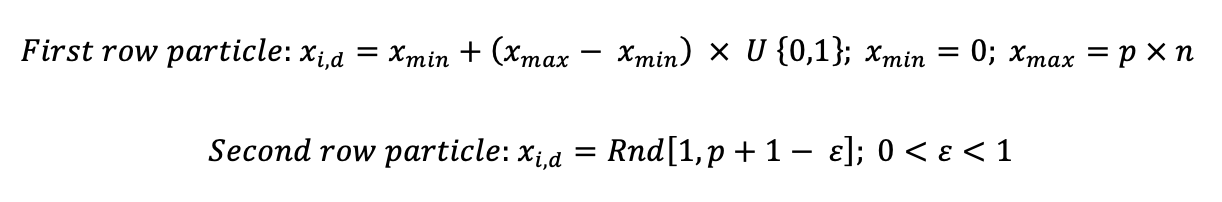

In [5]:
# Create a function to get the first row particle
def get_first_row_particle(n_node, x_min, x_max):
    first_row_raw = []
    for index in list(range(0, n_node)):
        result = round(x_min + ((x_max - x_min)*random.uniform(0,1)),2)
        first_row_raw.append(result)
    return first_row_raw

In [6]:
# Create a function to sort a particle by its dimension's value (Ascending)
def get_dimension_rank(particle):
    dimension_rank = list(ss.rankdata(particle))
    dimension_rank = [int(dimension) for dimension in dimension_rank]
    return dimension_rank

In [7]:
# Select the first p particles as the hub
def get_hub_allocation(dimension_rank, n_hub):
    selected_hub = dimension_rank[:n_hub]
    hub_number = list(range(1, n_hub+1))
    hub_dict = dict(zip(hub_number, selected_hub))
    return hub_dict

In [8]:
# Create a function to get the second row particle
def get_second_row_particle(n_node, n_hub, epsilon):
    second_row_particle=[]
    for index in list(range(1, n_node+1)):
        result = round(random.uniform(1, (n_hub+1)-epsilon),2)
        second_row_particle.append(result) 
    return second_row_particle

In [9]:
# Create a function to reallocate spoke to its cheapest hub
def dimension_reallocation(particle, n_node, cost_matrix, unique_hub):
    spoke_list = list(range(1,n_node+1))
    
    # Ensure the allocation is still within the number of nodes 
    for dimension in particle:
        if dimension > n_node:
            dimension = random.choice(range(0,n_node))
        else:
            pass
    
    # Ensure we obtain feasible solutions only
    for hub in unique_hub:
        if particle[hub-1] != hub:
            particle[hub-1] = hub
        else:
            pass
    
    for hub in unique_hub:
        spoke_list.remove(hub)
    
    spoke_index_list = [(spoke-1) for spoke in spoke_list]
    hub_index_list = [(hub-1) for hub in unique_hub]

    # Map each spoke to the potential hub and the respective cost between the spoke and the hub
    spoke_hub_cost={}
    for index in spoke_index_list:
        spoke_hub_cost[index+1] = [(cost_matrix[index][hub-1],hub) for hub in unique_hub]

    else:
        pass

    # Get the hub of each spoke that requires the lowest cost
    spoke_hub_mapping_with_lowest_cost = {}
    for spoke in list(spoke_hub_cost.keys()):
        cost = [ij[0] for ij in spoke_hub_cost[spoke]]
        hub = [ij[1] for ij in spoke_hub_cost[spoke] if ij[0] == min(cost)][0]
        spoke_hub_mapping_with_lowest_cost[spoke] = hub 

    # Map spoke index to hub index based on selected hub
    spoke_hub_index_mapping_with_lowest_cost = [] 
    for index in spoke_index_list:
        for hub in unique_hub:
            if spoke_hub_mapping_with_lowest_cost[index+1] == hub:
                spoke_hub_index_mapping_with_lowest_cost.append((index, hub-1))
    spoke_hub_index_mapping_with_lowest_cost = list(set(spoke_hub_index_mapping_with_lowest_cost))

    # Generate solution
    solution = particle.copy()
    for index_mapping in spoke_hub_index_mapping_with_lowest_cost:
        solution.pop(index_mapping[0])
        solution.insert(index_mapping[0],index_mapping[1]+1 )

    return solution

In [10]:
# Create a function to repair a particle in case the total hub generated != the given number of hub
def repair_particle(particle, n_node, n_hub, cost_matrix):
 
    # Declare input
    hubs_particle = []
    
    # Ensure the allocation is still within the number of nodes 
    for dimension in particle:
        if dimension > n_node:
            dimension = random.choice(range(0,n_node))
        else:
            pass
    
    # Declare unique hub in the particle as an input for gene repair operators
    unique_hub = [hub for hub in list(set(particle)) if hub != 0]

    # Ensure we obtain feaasible solutions only
    for hub in unique_hub:
        if particle[hub-1] != hub:
            particle[hub-1] = hub
        else:
            pass

    # Create a dictionary from the particle as an input for gene repair operators
    particle_dict = dict(zip(list(range(0,n_node)), particle))

    # Gene repair operators
    if len(unique_hub) == n_hub: # If the number of unique hub is the same as the desired number of unique hub
        for key in particle_dict:
            if particle_dict[key] == 0:
                particle[key] = random.choice(unique_hub) # Fill unassigned gene to random hub
            else:
                pass # Else, leave it as is
        particle_repaired = dimension_reallocation(particle, n_node, cost_matrix, unique_hub) # Reallocate spoke based on its lowest-cost hub
            
    elif len(unique_hub) > n_hub: # If the number of unique hub is greater than the desired number of unique hub
        repaired_hub_candidate = []
        for hub_combination in itertools.combinations(unique_hub, n_hub):
            repaired_hub_candidate.append(hub_combination) 
        repaired_unique_hub = random.choice(repaired_hub_candidate) # Reduce the number of unique hub by selecting hubs randomly
        for key in particle_dict:
            if particle_dict[key] == 0:
                particle[key] = random.choice(repaired_unique_hub) # Fill unassigned gene to random hub
            elif particle_dict[key] not in repaired_unique_hub:
                particle[key] = random.choice(repaired_unique_hub) # Fill infeasible gene to random hub
            else:
                pass      
        particle_repaired = dimension_reallocation(particle, n_node, cost_matrix, repaired_unique_hub) # Reallocate spoke based on its lowest-cost hub
        
    elif len(unique_hub) < n_hub:  # If the number of unique hub is less than the desired number of unique hub
        new_hub_required = n_hub - len(unique_hub) # Compute how many hubs to add
        possible_new_hub = list(range(1,n_node+1))
        for hub in unique_hub:
            possible_new_hub.remove(hub)
        random_new_hub = random.choices(possible_new_hub, k=new_hub_required) # Select random hub
        
        repaired_unique_hub = unique_hub + random_new_hub
        
        for hub in random_new_hub: # Place new hub to chromosome
            if particle[hub-1] != hub:
                particle[hub-1] = hub
            else:
                pass
        
        for key in particle_dict:
            if particle_dict[key] == 0:
                particle[key] = random.choice(repaired_unique_hub) # Fill unassigned gene to random hub
            elif particle_dict[key] not in repaired_unique_hub:
                particle[key] = random.choice(repaired_unique_hub) # Fill infeasible gene to random hub
            else:
                pass  
            
        particle_repaired = dimension_reallocation(particle, n_node, cost_matrix, repaired_unique_hub) # Reallocate spoke based on its lowest-cost hub
    else:
        pass
            
    return particle_repaired

### 2.2. Initial velocity

Initial velocity is computed using the formulation below:

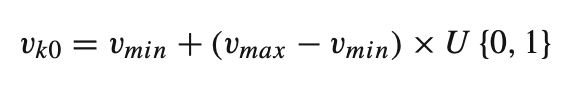

where:

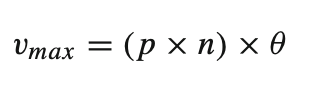

- p = Total hubs
- n = Total nodes
- theta = 0.01

In [11]:
# Create a function 
def get_initial_row_particle_velocity(particle, theta, n_node, n_hub):
    v_min = 0
    v_max = n_node * n_hub * theta
    particle_velocity = []
    for dimension in particle:
        dimension_velocity = round(v_min + ((v_max-v_min)*random.uniform(0,1)),2)
        particle_velocity.append(dimension_velocity)
    return particle_velocity

### 2.3. Updated velocity

Updated velocity is computed using the equation below:

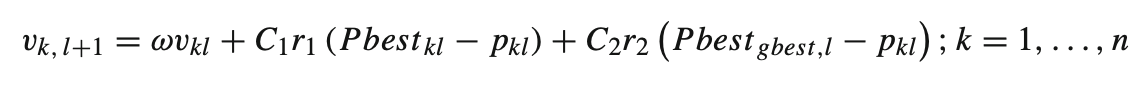

where:
- C1 and C2 = Acceleration coefficients
- ω = Inertia factor
- r1 = Random number in the range of [0 , 1]
- r2 = Random numbers in the range of [0 , 1]

In this model, C1 = C2 = 2 and ω = 1

In [12]:
def get_first_row_particle_updated_velocity(n_node, current_position, current_velocity, particle_best, global_best, inertia_factor, C):
    r1 = random.uniform(0,1)
    r2 = random.uniform(0,1)
    particle_velocity = []
    for dim_index in list(range(0, n_node)):
        dimension_velocity = (inertia_factor * current_velocity[dim_index]) + C*r1*(particle_best[dim_index] - current_position[dim_index]) + C*r2*(global_best[dim_index] - current_position[dim_index])
        dimension_velocity = round(dimension_velocity,2)
        particle_velocity.append(dimension_velocity)
    return particle_velocity

In [13]:
def get_second_row_particle_updated_velocity(n_node, current_position, current_velocity, particle_best, global_best, inertia_factor, C):
    r1 = random.uniform(0,1)
    r2 = random.uniform(0,1)
    particle_velocity = []
    for dim_index in list(range(0, n_node)):
        dimension_velocity = (inertia_factor * current_velocity[dim_index]) + C*r1*(particle_best[dim_index] - current_position[dim_index]) + C*r2*(global_best[dim_index] - current_position[dim_index])
        dimension_velocity = round(dimension_velocity,2)
        particle_velocity.append(dimension_velocity)
    return particle_velocity

### 2.4. Cost computation

In [14]:
# Create a function to compute the total distance in the network
def total_hub_flow(solution, node, flow_matrix):

    hub_spoke = {}
    for hub in set(solution):
        hub_spoke[hub] = [i for i,val in enumerate(solution) if val == hub] #takes the indexes of the hubs in the string
        for spokes in list(hub_spoke.values()):
            hub_spoke[hub] = [index for index in spokes if index != hub-1] #hubs and their spokes' indexes 
    hub_flows = {}
    from_hub_nodes_to_other_nodes = {} #including the parent hub and the other hubs
    for hub in set(solution):
        hub_flows[hub] = [list(flow_matrix[hub-1])] #from_hub_itself_to_other_nodes
        from_hub_nodes_to_other_nodes[hub] = [list(flow_matrix[spoke_index]) for spoke_index in hub_spoke[hub]]
        for flow_list in from_hub_nodes_to_other_nodes[hub]:
            hub_flows[hub].append(flow_list)
            
    total_hub_flow = {}
    for hub in set(solution):
        total_hub_flow[hub] = sum(list(itertools.chain.from_iterable(hub_flows[hub])))         
    return total_hub_flow

In [15]:
# Create a function to compute the total network cost of a particle
def total_network_cost(solution, node, flow_matrix, cost_matrix, alpha):
    total_flow_cost = 0
    for i in range(0, node):
        for j in range(0, node):
            flow_cost = flow_matrix[i][j]*(cost_matrix[i][solution[i]-1] + alpha*cost_matrix[solution[i]-1][solution[j]-1] +cost_matrix[solution[j]-1][j] )
            total_flow_cost = total_flow_cost + flow_cost
    return total_flow_cost

In [16]:
# Create a function to compute the total network cost/total hub flow
def compute_particle_cost(particle, node, flow_matrix, cost_matrix, alpha):
    total_hub_flow_value = sum(total_hub_flow(particle, node, flow_matrix).values())
    cost = round(total_network_cost(particle, node, flow_matrix, cost_matrix, alpha)/total_hub_flow_value,2)
    return cost

# 3. Particle Swarm Optimisation - Full code

In [17]:
def pso(n_node, n_hub, swarm_size, alpha, flow_matrix, cost_matrix, epsilon, theta, inertia_factor, C):
    iteration_count = 0
    x_min = 0
    x_max = n_node*n_hub
    while iteration_count < swarm_size: # Stopping criteria: The number of iteration = Swarm size
        
        #======================================= FIRST ITERATION =======================================#
        if iteration_count == 0:
            print(f'Initial iteration is starting...')
            # Declare inputs
            initial_row1_particles = []
            initial_row2_particles = []
            row1_particles_rank = []
            selected_hubs_dict = [] 
            initial_swarm_discrete = []
            initial_swarm_repaired = []
            initial_swarm_cost = []

            row2_updated_velocity = []
            first_row_new_position = []
            second_row_new_position = []

            # Step 1: Populate first row and second row particles
            counter = 0
            while counter < swarm_size:
                particle1 = get_first_row_particle(n_node, x_min, x_max)
                initial_row1_particles.append(particle1)
                particle2 = get_second_row_particle(n_node, n_hub, epsilon)
                initial_row2_particles.append(particle2)
                counter += 1

            row1_current_position = initial_row1_particles
            row2_current_position = initial_row2_particles

            for particle_index in list(range(0, swarm_size)):
                # Step 2: Rank first row particle
                row1_rank = get_dimension_rank(row1_current_position[particle_index])
                row1_particles_rank.append(row1_rank)

                # Step 3: Get the selected hubs from the first row particle     
                selected_hubs = get_hub_allocation(row1_particles_rank[particle_index], n_hub)
                selected_hubs_dict.append(selected_hubs)

                # Step 4: Allocate the hub to the second row particle to generate initial swarm result in discrete values
                particle = []
                for dimension_index in list(range(0, n_node)):
                    row2_dim_int = math.floor(row2_current_position[particle_index][dimension_index])
                    allocated_hub = selected_hubs_dict[particle_index][row2_dim_int]
                    particle.append(allocated_hub)
                initial_swarm_discrete.append(particle)

                # Step 5: Repair particles in the swarm
                particle_repaired = repair_particle(initial_swarm_discrete[particle_index], n_node, n_hub, cost_matrix)
                initial_swarm_repaired.append(particle_repaired)

                # Step 6: Compute fitness
                cost = compute_particle_cost(initial_swarm_repaired[particle_index], n_node, flow_matrix, cost_matrix, alpha)
                initial_swarm_cost.append(cost)

            # Step 7: Declare particle best and global best
                row1_particle_best = list(zip(initial_swarm_cost, row1_current_position))
                row1_global_best = min(row1_particle_best, key=itemgetter(0))
                row2_particle_best = list(zip(initial_swarm_cost, row2_current_position))
                row2_global_best = min(row2_particle_best, key=itemgetter(0))
                
            global_best_discrete_position = []
            for index in list(range(0, swarm_size)):
                if row1_particle_best[index][0] == row1_global_best[0]:
                    global_best_discrete_position = initial_swarm_repaired[index]
                else:
                    pass
                
            # Step 8: Compute initial velocity
            row1_initial_velocity = []
            row2_initial_velocity = []    
            for particle_index in list(range(0, swarm_size)):                
                row1_initial_velocity_temp = get_initial_row_particle_velocity(row1_current_position[particle_index], n_node, n_hub, theta)
                row1_initial_velocity.append(row1_initial_velocity_temp)

                row2_initial_velocity_temp = get_initial_row_particle_velocity(row2_current_position[particle_index], n_node, n_hub, theta)
                row2_initial_velocity.append(row2_initial_velocity_temp)
                
            row1_current_velocity = row1_initial_velocity
            row2_current_velocity = row2_initial_velocity
            
            # Step 9: Compute updated velocity
            row1_updated_velocity = []
            row1_global_best_position = row1_global_best[1]
            
            row2_updated_velocity = []
            row2_global_best_position = row2_global_best[1]
            
            for particle_index in list(range(0, swarm_size)):
                row1_particle_best_position = row1_particle_best[particle_index][1]
                row1_velocity_temp = get_first_row_particle_updated_velocity(n_node, row1_current_position[particle_index], row1_current_velocity[particle_index], row1_particle_best_position, row1_global_best_position, inertia_factor, C)
                row1_updated_velocity.append(row1_velocity_temp)

                row2_particle_best_position = row2_particle_best[particle_index][1]
                row2_velocity_temp = get_second_row_particle_updated_velocity(n_node, row2_current_position[particle_index], row2_current_velocity[particle_index], row2_particle_best_position, row2_global_best_position, inertia_factor, C)
                row2_updated_velocity.append(row2_velocity_temp)
                
            # Step 10: Update particle position
            row1_new_swarm_position_list = []
            for particle_index in list(range(0, swarm_size)):
                row1_new_particle_position = []
                for dim_index in list(range(0, n_node)):
                    row1_new_dimension_temp = row1_current_position[particle_index][dim_index] + row1_updated_velocity[particle_index][dim_index]
                    row1_new_dimension_temp = round(row1_new_dimension_temp, 2)
                    row1_new_particle_position.append(row1_new_dimension_temp)
                row1_new_swarm_position_list.append(row1_new_particle_position)

            row2_new_swarm_position_list = []
            for particle_index in list(range(0, swarm_size)):
                row2_new_particle_position = []
                for dim_index in list(range(0, n_node)):
                    row2_new_dimension_temp = row2_current_position[particle_index][dim_index] + row2_updated_velocity[particle_index][dim_index]
                    row2_new_dimension_temp = round(row2_new_dimension_temp, 2)
                    row2_new_particle_position.append(row2_new_dimension_temp)
                row2_new_swarm_position_list.append(row2_new_particle_position)  
                
            # Step 11: Re-declare the particle best and global best for the next iteration
            old_row1_particle_best = row1_particle_best
            old_row2_particle_best = row2_particle_best
            old_global_best = row1_global_best[0]
            
         
        #======================================= SUBSEQUENT ITERATION =======================================#
        elif iteration_count > 0:
            # Step 1: Populate second row particles
            new_row2_particles = []
            counter = 0
            while counter < swarm_size:
                particle2 = get_second_row_particle(n_node, n_hub, epsilon)
                new_row2_particles.append(particle2)
                counter += 1
            
            # Declare current positions
            row1_current_position = row1_new_swarm_position_list
            row2_current_position = new_row2_particles
            row1_particles_rank = []
            selected_hubs_dict = []
            new_swarm_discrete = []
            new_swarm_repaired = []
            new_swarm_cost = []
            row1_particle_best = []
            
            for particle_index in list(range(0, swarm_size)):
                # Step 2: Rank first row particle
                row1_rank = get_dimension_rank(row1_current_position[particle_index])
                row1_particles_rank.append(row1_rank)

                # Step 3: Get the selected hubs from the first row particle     
                selected_hubs = get_hub_allocation(row1_particles_rank[particle_index], n_hub)
                selected_hubs_dict.append(selected_hubs)

                # Step 4: Allocate the hub to the second row particle to generate new swarm in discrete values
                particle = []
                for dimension_index in list(range(0, n_node)):
                    row2_dim_int = math.floor(row2_current_position[particle_index][dimension_index])
                    allocated_hub = selected_hubs_dict[particle_index][row2_dim_int]
                    particle.append(allocated_hub)
                new_swarm_discrete.append(particle)

                # Step 5: Repair particles in the swarm
                particle_repaired = repair_particle(new_swarm_discrete[particle_index], n_node, n_hub, cost_matrix)
                new_swarm_repaired.append(particle_repaired)

                # Step 6: Compute fitness
                cost = compute_particle_cost(new_swarm_repaired[particle_index], n_node, flow_matrix, cost_matrix, alpha)
                new_swarm_cost.append(cost)

            # Step 7: Declare particle best and global best  
                if new_swarm_cost[particle_index] < old_row1_particle_best[particle_index][0]:
                    row1_particle_best.append((new_swarm_cost[particle_index], row1_current_position[particle_index]))
                else:
                    row1_particle_best.append(old_row1_particle_best[particle_index])
                    
                if new_swarm_cost[particle_index] < old_row2_particle_best[particle_index][0]:
                    row2_particle_best.append((new_swarm_cost[particle_index], row2_current_position[particle_index]))
                else:
                    row2_particle_best.append(old_row2_particle_best[particle_index])    
            
            row1_global_best = min(row1_particle_best, key=itemgetter(0))
            row2_global_best = min(row1_particle_best, key=itemgetter(0))
            
            global_best_discrete_position = []
            for index in list(range(0, swarm_size)):
                if row1_particle_best[index][0] == row1_global_best[0]:
                    global_best_discrete_position = new_swarm_repaired[index]
                else:
                    pass
                
            # Step 8 is skipped because we no longer have to compute the initial velocity
            
            # Step 9: Compute updated velocity
            row1_updated_velocity = []
            row1_global_best_position = row1_global_best[1]
            
            row2_updated_velocity = []
            row2_global_best_position = row2_global_best[1]
            
            for particle_index in list(range(0, swarm_size)):
                row1_particle_best_position = row1_particle_best[particle_index][1]
                row1_velocity_temp = get_first_row_particle_updated_velocity(n_node, row1_current_position[particle_index], row1_current_velocity[particle_index], row1_particle_best_position, row1_global_best_position, inertia_factor, C)
                row1_updated_velocity.append(row1_velocity_temp)

                row2_particle_best_position = row2_particle_best[particle_index][1]
                row2_velocity_temp = get_second_row_particle_updated_velocity(n_node, row2_current_position[particle_index], row2_current_velocity[particle_index], row2_particle_best_position, row2_global_best_position, inertia_factor, C)
                row2_updated_velocity.append(row2_velocity_temp) 
                
            # Step 10: Update particle position
            row1_new_swarm_position_list = []
            for particle_index in list(range(0, swarm_size)):
                row1_new_particle_position = []
                for dim_index in list(range(0, n_node)):
                    row1_new_dimension_temp = row1_current_position[particle_index][dim_index] + row1_updated_velocity[particle_index][dim_index]
                    row1_new_dimension_temp = round(row1_new_dimension_temp, 2)
                    row1_new_particle_position.append(row1_new_dimension_temp)
                row1_new_swarm_position_list.append(row1_new_particle_position)

            row2_new_swarm_position_list = []
            for particle_index in list(range(0, swarm_size)):
                row2_new_particle_position = []
                for dim_index in list(range(0, n_node)):
                    row2_new_dimension_temp = row2_current_position[particle_index][dim_index] + row2_updated_velocity[particle_index][dim_index]
                    row2_new_dimension_temp = round(row2_new_dimension_temp, 2)
                    row2_new_particle_position.append(row2_new_dimension_temp)
                row2_new_swarm_position_list.append(row2_new_particle_position)     
            
            # Step 11: Re-declare the particle best and global best for the next iteration
            old_row1_particle_best = row1_particle_best
            old_row2_particle_best = row2_particle_best
            old_global_best = row1_global_best[0]

        iteration_count += 1
    
    # If all iterations are completed, compute the global best (total network cost), retrieve best configuration of the hub-and-spoke network, and the retrieve selected hub
    global_best = row1_global_best[0]
    best_config = global_best_discrete_position
    selected_hubs = list(set(best_config))
    global_best_solution = [global_best, best_config, selected_hubs]
    
    print(f'Global best value: {global_best}')
    return global_best_solution

# 4. Implementation on the benchmark problems

Note: CASE 1 - CASE 4 are skipped because we are interested in implementing this algorithm for n >= 25

#### CASE 5: CAB dataset, n_node = 25, n_hub = 3, alpha = 0.2

In [18]:
%%time

start_time = time.time()

n_node=25
n_hub=3
swarm_size=100
alpha = 0.2
epsilon=0.01
x_min=0
x_max = n_node*n_hub
flow_matrix = CAB25_flow
cost_matrix = CAB25_cost
theta = 0.1
inertia_factor = 1
C = 2

global_minimum_solution_list = []
replication = 0
n_replication = 10

while replication < n_replication:
    PSO_result = pso(n_node, n_hub, swarm_size, alpha, flow_matrix, cost_matrix, epsilon, theta, inertia_factor, C)
    global_minimum_solution_list.append(PSO_result)
    print(f'====================== REPLICATION {replication} IS FINISHED ======================\n')
    print('\n')
    replication += 1
    
case5_df = pd.DataFrame(global_minimum_solution_list, columns=['cost','node','unique_hub'])
avg_tnc = round(case5_df["cost"].mean(),2)
best_tnc = round(case5_df["cost"].min(),2)
gap = round((best_tnc - case5_opt_sol)/best_tnc*100,2)
avg_cpu_time = round((time.time() - start_time)/n_replication,2)

print(f'AVG CPU time: {avg_cpu_time} seconds')
print(f'Optimal solution answer: {case5_opt_sol}')
print(f'My optimal solution: {best_tnc}')
print(f'AVG optimal solution: {avg_tnc}')
print(f'Gap (%): {gap}%')

Initial iteration is starting...
Global best value: 770.55
====================== REPLICATION 0 IS FINISHED ======================



Initial iteration is starting...
Global best value: 774.31
====================== REPLICATION 1 IS FINISHED ======================



Initial iteration is starting...
Global best value: 770.55
====================== REPLICATION 2 IS FINISHED ======================



Initial iteration is starting...
Global best value: 774.31
====================== REPLICATION 3 IS FINISHED ======================



Initial iteration is starting...
Global best value: 770.55
====================== REPLICATION 4 IS FINISHED ======================



Initial iteration is starting...
Global best value: 770.55
====================== REPLICATION 5 IS FINISHED ======================



Initial iteration is starting...
Global best value: 770.55
====================== REPLICATION 6 IS FINISHED ======================



Initial iteration is starting...
Global best value: 770.55
===

#### CASE 6: CAB dataset, n_node = 25, n_hub = 3, alpha = 0.8

In [19]:
%%time

start_time = time.time()

n_node=25
n_hub=3
swarm_size=100
alpha = 0.8
epsilon=0.01
x_min=0
x_max = n_node*n_hub
flow_matrix = CAB25_flow
cost_matrix = CAB25_cost
theta = 0.1
inertia_factor = 1
C = 2

global_minimum_solution_list = []
replication = 0
n_replication = 10

while replication < n_replication:
    PSO_result = pso(n_node, n_hub, swarm_size, alpha, flow_matrix, cost_matrix, epsilon, theta, inertia_factor, C)
    global_minimum_solution_list.append(PSO_result)
    print(f'====================== REPLICATION {replication} IS FINISHED ======================\n')
    print('\n')
    replication += 1
    
case6_df = pd.DataFrame(global_minimum_solution_list, columns=['cost','node','unique_hub'])
avg_tnc = round(case6_df["cost"].mean(),2)
best_tnc = round(case6_df["cost"].min(),2)
gap = round((best_tnc - case6_opt_sol)/best_tnc*100,2)
avg_cpu_time = round((time.time() - start_time)/n_replication,2)

print(f'AVG CPU time: {avg_cpu_time} seconds')
print(f'Optimal solution answer: {case6_opt_sol}')
print(f'My optimal solution: {best_tnc}')
print(f'AVG optimal solution: {avg_tnc}')
print(f'Gap (%): {gap}%')

Initial iteration is starting...
Global best value: 1170.66
====================== REPLICATION 0 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1184.98
====================== REPLICATION 1 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1170.47
====================== REPLICATION 2 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1180.48
====================== REPLICATION 3 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1170.47
====================== REPLICATION 4 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1180.48
====================== REPLICATION 5 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1170.66
====================== REPLICATION 6 IS FINISHED ======================



Initial iteration is starting...
Global best value: 118

#### CASE 7: CAB dataset, n_node = 25, n_hub = 5, alpha = 0.2

In [20]:
%%time

start_time = time.time()

n_node=25
n_hub=5
swarm_size=100
alpha = 0.2
epsilon=0.01
x_min=0
x_max = n_node*n_hub
flow_matrix = CAB25_flow
cost_matrix = CAB25_cost
theta = 0.1
inertia_factor = 1
C = 2

global_minimum_solution_list = []
replication = 0
n_replication = 10

while replication < n_replication:
    PSO_result = pso(n_node, n_hub, swarm_size, alpha, flow_matrix, cost_matrix, epsilon, theta, inertia_factor, C)
    global_minimum_solution_list.append(PSO_result)
    print(f'====================== REPLICATION {replication} IS FINISHED ======================\n')
    print('\n')
    replication += 1
    
case7_df = pd.DataFrame(global_minimum_solution_list, columns=['cost','node','unique_hub'])
avg_tnc = round(case7_df["cost"].mean(),2)
best_tnc = round(case7_df["cost"].min(),2)
gap = round((best_tnc - case7_opt_sol)/best_tnc*100,2)
avg_cpu_time = round((time.time() - start_time)/n_replication,2)

print(f'AVG CPU time: {avg_cpu_time} seconds')
print(f'Optimal solution answer: {case7_opt_sol}')
print(f'My optimal solution: {best_tnc}')
print(f'AVG optimal solution: {avg_tnc}')
print(f'Gap (%): {gap}%')

Initial iteration is starting...
Global best value: 541.88
====================== REPLICATION 0 IS FINISHED ======================



Initial iteration is starting...
Global best value: 565.75
====================== REPLICATION 1 IS FINISHED ======================



Initial iteration is starting...
Global best value: 541.19
====================== REPLICATION 2 IS FINISHED ======================



Initial iteration is starting...
Global best value: 541.19
====================== REPLICATION 3 IS FINISHED ======================



Initial iteration is starting...
Global best value: 574.87
====================== REPLICATION 4 IS FINISHED ======================



Initial iteration is starting...
Global best value: 541.19
====================== REPLICATION 5 IS FINISHED ======================



Initial iteration is starting...
Global best value: 564.29
====================== REPLICATION 6 IS FINISHED ======================



Initial iteration is starting...
Global best value: 541.88
===

#### CASE 8: CAB dataset, n_node = 25, n_hub = 5, alpha = 0.8

In [21]:
%%time

start_time = time.time()

n_node=25
n_hub=5
swarm_size=100
alpha = 0.8
epsilon=0.01
x_min=0
x_max = n_node*n_hub
flow_matrix = CAB25_flow
cost_matrix = CAB25_cost
theta = 0.1
inertia_factor = 1
C = 2

global_minimum_solution_list = []
replication = 0
n_replication = 10

while replication < n_replication:
    PSO_result = pso(n_node, n_hub, swarm_size, alpha, flow_matrix, cost_matrix, epsilon, theta, inertia_factor, C)
    global_minimum_solution_list.append(PSO_result)
    print(f'====================== REPLICATION {replication} IS FINISHED ======================\n')
    print('\n')
    replication += 1
    
case8_df = pd.DataFrame(global_minimum_solution_list, columns=['cost','node','unique_hub'])
avg_tnc = round(case8_df["cost"].mean(),2)
best_tnc = round(case8_df["cost"].min(),2)
gap = round((best_tnc - case8_opt_sol)/best_tnc*100,2)
avg_cpu_time = round((time.time() - start_time)/n_replication,2)

print(f'AVG CPU time: {avg_cpu_time} seconds')
print(f'Optimal solution answer: {case8_opt_sol}')
print(f'My optimal solution: {best_tnc}')
print(f'AVG optimal solution: {avg_tnc}')
print(f'Gap (%): {gap}%')

Initial iteration is starting...
Global best value: 1036.54
====================== REPLICATION 0 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1047.28
====================== REPLICATION 1 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1052.61
====================== REPLICATION 2 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1046.01
====================== REPLICATION 3 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1045.94
====================== REPLICATION 4 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1036.54
====================== REPLICATION 5 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1036.54
====================== REPLICATION 6 IS FINISHED ======================



Initial iteration is starting...
Global best value: 105

#### CASE 9: TR dataset, n_node = 55, n_hub = 3, alpha = 0.2

In [22]:
%%time

start_time = time.time()

n_node=55
n_hub=3
swarm_size=100
alpha = 0.2
epsilon=0.01
x_min=0
x_max = n_node*n_hub
flow_matrix = TR55_flow
cost_matrix = TR55_cost
theta = 0.1
inertia_factor = 1
C = 2

global_minimum_solution_list = []
replication = 0
n_replication = 10

while replication < n_replication:
    PSO_result = pso(n_node, n_hub, swarm_size, alpha, flow_matrix, cost_matrix, epsilon, theta, inertia_factor, C)
    global_minimum_solution_list.append(PSO_result)
    print(f'====================== REPLICATION {replication} IS FINISHED ======================\n')
    print('\n')
    replication += 1
    
case9_df = pd.DataFrame(global_minimum_solution_list, columns=['cost','node','unique_hub'])
avg_tnc = round(case9_df["cost"].mean(),2)
best_tnc = round(case9_df["cost"].min(),2)
gap = round((best_tnc - case9_opt_sol)/best_tnc*100,2)
avg_cpu_time = round((time.time() - start_time)/n_replication,2)

print(f'AVG CPU time: {avg_cpu_time} seconds')
print(f'Optimal solution answer: {case9_opt_sol}')
print(f'My optimal solution: {best_tnc}')
print(f'AVG optimal solution: {avg_tnc}')
print(f'Gap (%): {gap}%')

Initial iteration is starting...
Global best value: 604.8
====================== REPLICATION 0 IS FINISHED ======================



Initial iteration is starting...
Global best value: 623.74
====================== REPLICATION 1 IS FINISHED ======================



Initial iteration is starting...
Global best value: 592.82
====================== REPLICATION 2 IS FINISHED ======================



Initial iteration is starting...
Global best value: 592.82
====================== REPLICATION 3 IS FINISHED ======================



Initial iteration is starting...
Global best value: 592.82
====================== REPLICATION 4 IS FINISHED ======================



Initial iteration is starting...
Global best value: 602.62
====================== REPLICATION 5 IS FINISHED ======================



Initial iteration is starting...
Global best value: 608.3
====================== REPLICATION 6 IS FINISHED ======================



Initial iteration is starting...
Global best value: 596.25
=====

#### CASE 10: TR dataset, n_node = 55, n_hub = 3, alpha = 0.8

In [23]:
%%time

start_time = time.time()

n_node=55
n_hub=3
swarm_size=100
alpha = 0.8
epsilon=0.01
x_min=0
x_max = n_node*n_hub
flow_matrix = TR55_flow
cost_matrix = TR55_cost
theta = 0.1
inertia_factor = 1
C = 2

global_minimum_solution_list = []
replication = 0
n_replication = 10

while replication < n_replication:
    PSO_result = pso(n_node, n_hub, swarm_size, alpha, flow_matrix, cost_matrix, epsilon, theta, inertia_factor, C)
    global_minimum_solution_list.append(PSO_result)
    print(f'====================== REPLICATION {replication} IS FINISHED ======================\n')
    print('\n')
    replication += 1
    
case10_df = pd.DataFrame(global_minimum_solution_list, columns=['cost','node','unique_hub'])
avg_tnc = round(case10_df["cost"].mean(),2)
best_tnc = round(case10_df["cost"].min(),2)
gap = round((best_tnc - case10_opt_sol)/best_tnc*100,2)
avg_cpu_time = round((time.time() - start_time)/n_replication,2)

print(f'AVG CPU time: {avg_cpu_time} seconds')
print(f'Optimal solution answer: {case10_opt_sol}')
print(f'My optimal solution: {best_tnc}')
print(f'AVG optimal solution: {avg_tnc}')
print(f'Gap (%): {gap}%')

Initial iteration is starting...
Global best value: 890.63
====================== REPLICATION 0 IS FINISHED ======================



Initial iteration is starting...
Global best value: 879.44
====================== REPLICATION 1 IS FINISHED ======================



Initial iteration is starting...
Global best value: 867.55
====================== REPLICATION 2 IS FINISHED ======================



Initial iteration is starting...
Global best value: 890.63
====================== REPLICATION 3 IS FINISHED ======================



Initial iteration is starting...
Global best value: 857.64
====================== REPLICATION 4 IS FINISHED ======================



Initial iteration is starting...
Global best value: 877.39
====================== REPLICATION 5 IS FINISHED ======================



Initial iteration is starting...
Global best value: 861.1
====================== REPLICATION 6 IS FINISHED ======================



Initial iteration is starting...
Global best value: 892.82
====

#### CASE 11: TR dataset, n_node = 55, n_hub = 5, alpha = 0.2

In [24]:
%%time

start_time = time.time()

n_node=55
n_hub=5
swarm_size=100
alpha = 0.2
epsilon=0.01
x_min=0
x_max = n_node*n_hub
flow_matrix = TR55_flow
cost_matrix = TR55_cost
theta = 0.1
inertia_factor = 1
C = 2

global_minimum_solution_list = []
replication = 0
n_replication = 10

while replication < n_replication:
    PSO_result = pso(n_node, n_hub, swarm_size, alpha, flow_matrix, cost_matrix, epsilon, theta, inertia_factor, C)
    global_minimum_solution_list.append(PSO_result)
    print(f'====================== REPLICATION {replication} IS FINISHED ======================\n')
    print('\n')
    replication += 1
    
case11_df = pd.DataFrame(global_minimum_solution_list, columns=['cost','node','unique_hub'])
avg_tnc = round(case11_df["cost"].mean(),2)
best_tnc = round(case11_df["cost"].min(),2)
gap = round((best_tnc - case11_opt_sol)/best_tnc*100,2)
avg_cpu_time = round((time.time() - start_time)/n_replication,2)

print(f'AVG CPU time: {avg_cpu_time} seconds')
print(f'Optimal solution answer: {case11_opt_sol}')
print(f'My optimal solution: {best_tnc}')
print(f'AVG optimal solution: {avg_tnc}')
print(f'Gap (%): {gap}%')

Initial iteration is starting...
Global best value: 481.7
====================== REPLICATION 0 IS FINISHED ======================



Initial iteration is starting...
Global best value: 446.67
====================== REPLICATION 1 IS FINISHED ======================



Initial iteration is starting...
Global best value: 460.43
====================== REPLICATION 2 IS FINISHED ======================



Initial iteration is starting...
Global best value: 475.67
====================== REPLICATION 3 IS FINISHED ======================



Initial iteration is starting...
Global best value: 474.76
====================== REPLICATION 4 IS FINISHED ======================



Initial iteration is starting...
Global best value: 451.57
====================== REPLICATION 5 IS FINISHED ======================



Initial iteration is starting...
Global best value: 457.28
====================== REPLICATION 6 IS FINISHED ======================



Initial iteration is starting...
Global best value: 458.69
====

#### CASE 12: TR dataset, n_node = 55, n_hub = 5, alpha = 0.8

In [25]:
%%time

start_time = time.time()

n_node=55
n_hub=5
swarm_size=100
alpha = 0.8
epsilon=0.01
x_min=0
x_max = n_node*n_hub
flow_matrix = TR55_flow
cost_matrix = TR55_cost
theta = 0.1
inertia_factor = 1
C = 2

global_minimum_solution_list = []
replication = 0
n_replication = 10

while replication < n_replication:
    PSO_result = pso(n_node, n_hub, swarm_size, alpha, flow_matrix, cost_matrix, epsilon, theta, inertia_factor, C)
    global_minimum_solution_list.append(PSO_result)
    print(f'====================== REPLICATION {replication} IS FINISHED ======================\n')
    print('\n')
    replication += 1
    
case12_df = pd.DataFrame(global_minimum_solution_list, columns=['cost','node','unique_hub'])
avg_tnc = round(case12_df["cost"].mean(),2)
best_tnc = round(case12_df["cost"].min(),2)
gap = round((best_tnc - case12_opt_sol)/best_tnc*100,2)
avg_cpu_time = round((time.time() - start_time)/n_replication,2)

print(f'AVG CPU time: {avg_cpu_time} seconds')
print(f'Optimal solution answer: {case12_opt_sol}')
print(f'My optimal solution: {best_tnc}')
print(f'AVG optimal solution: {avg_tnc}')
print(f'Gap (%): {gap}%')

Initial iteration is starting...
Global best value: 813.97
====================== REPLICATION 0 IS FINISHED ======================



Initial iteration is starting...
Global best value: 795.19
====================== REPLICATION 1 IS FINISHED ======================



Initial iteration is starting...
Global best value: 796.19
====================== REPLICATION 2 IS FINISHED ======================



Initial iteration is starting...
Global best value: 804.71
====================== REPLICATION 3 IS FINISHED ======================



Initial iteration is starting...
Global best value: 794.13
====================== REPLICATION 4 IS FINISHED ======================



Initial iteration is starting...
Global best value: 793.95
====================== REPLICATION 5 IS FINISHED ======================



Initial iteration is starting...
Global best value: 807.92
====================== REPLICATION 6 IS FINISHED ======================



Initial iteration is starting...
Global best value: 796.73
===

#### CASE 13: TR dataset, n_node = 81, n_hub = 5, alpha = 0.2

In [26]:
%%time

start_time = time.time()

n_node=81
n_hub=5
swarm_size=100
alpha = 0.2
epsilon=0.01
x_min=0
x_max = n_node*n_hub
flow_matrix = TR81_flow
cost_matrix = TR81_cost
theta = 0.1
inertia_factor = 1
C = 2

global_minimum_solution_list = []
replication = 0
n_replication = 10

while replication < n_replication:
    PSO_result = pso(n_node, n_hub, swarm_size, alpha, flow_matrix, cost_matrix, epsilon, theta, inertia_factor, C)
    global_minimum_solution_list.append(PSO_result)
    print(f'====================== REPLICATION {replication} IS FINISHED ======================\n')
    print('\n')
    replication += 1
    
case13_df = pd.DataFrame(global_minimum_solution_list, columns=['cost','node','unique_hub'])
avg_tnc = round(case13_df["cost"].mean(),2)
best_tnc = round(case13_df["cost"].min(),2)
gap = round((best_tnc - case13_opt_sol)/best_tnc*100,2)
avg_cpu_time = round((time.time() - start_time)/n_replication,2)

print(f'AVG CPU time: {avg_cpu_time} seconds')
print(f'Optimal solution answer: {case13_opt_sol}')
print(f'My optimal solution: {best_tnc}')
print(f'AVG optimal solution: {avg_tnc}')
print(f'Gap (%): {gap}%')

Initial iteration is starting...
Global best value: 543.95
====================== REPLICATION 0 IS FINISHED ======================



Initial iteration is starting...
Global best value: 544.76
====================== REPLICATION 1 IS FINISHED ======================



Initial iteration is starting...
Global best value: 527.06
====================== REPLICATION 2 IS FINISHED ======================



Initial iteration is starting...
Global best value: 518.86
====================== REPLICATION 3 IS FINISHED ======================



Initial iteration is starting...
Global best value: 520.06
====================== REPLICATION 4 IS FINISHED ======================



Initial iteration is starting...
Global best value: 525.11
====================== REPLICATION 5 IS FINISHED ======================



Initial iteration is starting...
Global best value: 534.23
====================== REPLICATION 6 IS FINISHED ======================



Initial iteration is starting...
Global best value: 531.95
===

#### CASE 14: TR dataset, n_node = 81, n_hub = 5, alpha = 0.8

In [27]:
%%time

start_time = time.time()

n_node=81
n_hub=5
swarm_size=100
alpha = 0.8
epsilon=0.01
x_min=0
x_max = n_node*n_hub
flow_matrix = TR81_flow
cost_matrix = TR81_cost
theta = 0.1
inertia_factor = 1
C = 2

global_minimum_solution_list = []
replication = 0
n_replication = 10

while replication < n_replication:
    PSO_result = pso(n_node, n_hub, swarm_size, alpha, flow_matrix, cost_matrix, epsilon, theta, inertia_factor, C)
    global_minimum_solution_list.append(PSO_result)
    print(f'====================== REPLICATION {replication} IS FINISHED ======================\n')
    print('\n')
    replication += 1
    
case14_df = pd.DataFrame(global_minimum_solution_list, columns=['cost','node','unique_hub'])
avg_tnc = round(case14_df["cost"].mean(),2)
best_tnc = round(case14_df["cost"].min(),2)
gap = round((best_tnc - case14_opt_sol)/best_tnc*100,2)
avg_cpu_time = round((time.time() - start_time)/n_replication,2)

print(f'AVG CPU time: {avg_cpu_time} seconds')
print(f'Optimal solution answer: {case14_opt_sol}')
print(f'My optimal solution: {best_tnc}')
print(f'AVG optimal solution: {avg_tnc}')
print(f'Gap (%): {gap}%')

Initial iteration is starting...
Global best value: 866.35
====================== REPLICATION 0 IS FINISHED ======================



Initial iteration is starting...
Global best value: 836.42
====================== REPLICATION 1 IS FINISHED ======================



Initial iteration is starting...
Global best value: 849.21
====================== REPLICATION 2 IS FINISHED ======================



Initial iteration is starting...
Global best value: 861.31
====================== REPLICATION 3 IS FINISHED ======================



Initial iteration is starting...
Global best value: 878.02
====================== REPLICATION 4 IS FINISHED ======================



Initial iteration is starting...
Global best value: 855.53
====================== REPLICATION 5 IS FINISHED ======================



Initial iteration is starting...
Global best value: 838.54
====================== REPLICATION 6 IS FINISHED ======================



Initial iteration is starting...
Global best value: 837.83
===

#### CASE 15: TR dataset, n_node = 81, n_hub = 7, alpha = 0.2

In [28]:
%%time

start_time = time.time()

n_node=81
n_hub=7
swarm_size=100
alpha = 0.2
epsilon=0.01
x_min=0
x_max = n_node*n_hub
flow_matrix = TR81_flow
cost_matrix = TR81_cost
theta = 0.1
inertia_factor = 1
C = 2

global_minimum_solution_list = []
replication = 0
n_replication = 10

while replication < n_replication:
    PSO_result = pso(n_node, n_hub, swarm_size, alpha, flow_matrix, cost_matrix, epsilon, theta, inertia_factor, C)
    global_minimum_solution_list.append(PSO_result)
    print(f'====================== REPLICATION {replication} IS FINISHED ======================\n')
    print('\n')
    replication += 1
    
case15_df = pd.DataFrame(global_minimum_solution_list, columns=['cost','node','unique_hub'])
avg_tnc = round(case15_df["cost"].mean(),2)
best_tnc = round(case15_df["cost"].min(),2)
gap = round((best_tnc - case15_opt_sol)/best_tnc*100,2)
avg_cpu_time = round((time.time() - start_time)/n_replication,2)

print(f'AVG CPU time: {avg_cpu_time} seconds')
print(f'Optimal solution answer: {case15_opt_sol}')
print(f'My optimal solution: {best_tnc}')
print(f'AVG optimal solution: {avg_tnc}')
print(f'Gap (%): {gap}%')

Initial iteration is starting...
Global best value: 437.23
====================== REPLICATION 0 IS FINISHED ======================



Initial iteration is starting...
Global best value: 434.65
====================== REPLICATION 1 IS FINISHED ======================



Initial iteration is starting...
Global best value: 443.39
====================== REPLICATION 2 IS FINISHED ======================



Initial iteration is starting...
Global best value: 453.37
====================== REPLICATION 3 IS FINISHED ======================



Initial iteration is starting...
Global best value: 457.6
====================== REPLICATION 4 IS FINISHED ======================



Initial iteration is starting...
Global best value: 464.38
====================== REPLICATION 5 IS FINISHED ======================



Initial iteration is starting...
Global best value: 454.93
====================== REPLICATION 6 IS FINISHED ======================



Initial iteration is starting...
Global best value: 459.34
====

#### CASE 16: TR dataset, n_node = 81, n_hub = 7, alpha = 0.8

In [29]:
%%time

start_time = time.time()

n_node=81
n_hub=7
swarm_size=100
alpha = 0.8
epsilon=0.01
x_min=0
x_max = n_node*n_hub
flow_matrix = TR81_flow
cost_matrix = TR81_cost
theta = 0.1
inertia_factor = 1
C = 2

global_minimum_solution_list = []
replication = 0
n_replication = 10

while replication < n_replication:
    PSO_result = pso(n_node, n_hub, swarm_size, alpha, flow_matrix, cost_matrix, epsilon, theta, inertia_factor, C)
    global_minimum_solution_list.append(PSO_result)
    print(f'====================== REPLICATION {replication} IS FINISHED ======================\n')
    print('\n')
    replication += 1
    
case16_df = pd.DataFrame(global_minimum_solution_list, columns=['cost','node','unique_hub'])
avg_tnc = round(case16_df["cost"].mean(),2)
best_tnc = round(case16_df["cost"].min(),2)
gap = round((best_tnc - case16_opt_sol)/best_tnc*100,2)
avg_cpu_time = round((time.time() - start_time)/n_replication,2)

print(f'AVG CPU time: {avg_cpu_time} seconds')
print(f'Optimal solution answer: {case16_opt_sol}')
print(f'My optimal solution: {best_tnc}')
print(f'AVG optimal solution: {avg_tnc}')
print(f'Gap (%): {gap}%')

Initial iteration is starting...
Global best value: 808.88
====================== REPLICATION 0 IS FINISHED ======================



Initial iteration is starting...
Global best value: 814.07
====================== REPLICATION 1 IS FINISHED ======================



Initial iteration is starting...
Global best value: 822.49
====================== REPLICATION 2 IS FINISHED ======================



Initial iteration is starting...
Global best value: 798.86
====================== REPLICATION 3 IS FINISHED ======================



Initial iteration is starting...
Global best value: 823.8
====================== REPLICATION 4 IS FINISHED ======================



Initial iteration is starting...
Global best value: 808.26
====================== REPLICATION 5 IS FINISHED ======================



Initial iteration is starting...
Global best value: 812.73
====================== REPLICATION 6 IS FINISHED ======================



Initial iteration is starting...
Global best value: 838.76
====

#### CASE 17: RGP dataset, n_node = 100, n_hub = 7, alpha = 0.2

In [30]:
%%time

start_time = time.time()

n_node=100
n_hub=7
swarm_size=50
alpha = 0.2
epsilon=0.01
x_min=0
x_max = n_node*n_hub
flow_matrix = RGP100_flow
cost_matrix = RGP100_cost
theta = 0.1
inertia_factor = 1
C = 2

global_minimum_solution_list = []
replication = 0
n_replication = 10

while replication < n_replication:
    PSO_result = pso(n_node, n_hub, swarm_size, alpha, flow_matrix, cost_matrix, epsilon, theta, inertia_factor, C)
    global_minimum_solution_list.append(PSO_result)
    print(f'====================== REPLICATION {replication} IS FINISHED ======================\n')
    print('\n')
    replication += 1
    
case17_df = pd.DataFrame(global_minimum_solution_list, columns=['cost','node','unique_hub'])
avg_tnc = round(case17_df["cost"].mean(),2)
best_tnc = round(case17_df["cost"].min(),2)
gap = round((best_tnc - case17_opt_sol)/best_tnc*100,2)
avg_cpu_time = round((time.time() - start_time)/n_replication,2)

print(f'AVG CPU time: {avg_cpu_time} seconds')
print(f'Optimal solution answer: {case17_opt_sol}')
print(f'My optimal solution: {best_tnc}')
print(f'AVG optimal solution: {avg_tnc}')
print(f'Gap (%): {gap}%')

Initial iteration is starting...
Global best value: 1284.94
====================== REPLICATION 0 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1289.83
====================== REPLICATION 1 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1281.25
====================== REPLICATION 2 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1299.63
====================== REPLICATION 3 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1280.47
====================== REPLICATION 4 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1295.31
====================== REPLICATION 5 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1295.94
====================== REPLICATION 6 IS FINISHED ======================



Initial iteration is starting...
Global best value: 129

#### CASE 18: RGP dataset, n_node = 100, n_hub = 7, alpha = 0.8

In [31]:
%%time

start_time = time.time()

n_node=100
n_hub=7
swarm_size=50
alpha = 0.8
epsilon=0.01
x_min=0
x_max = n_node*n_hub
flow_matrix = RGP100_flow
cost_matrix = RGP100_cost
theta = 0.1
inertia_factor = 1
C = 2

global_minimum_solution_list = []
replication = 0
n_replication = 10

while replication < n_replication:
    PSO_result = pso(n_node, n_hub, swarm_size, alpha, flow_matrix, cost_matrix, epsilon, theta, inertia_factor, C)
    global_minimum_solution_list.append(PSO_result)
    print(f'====================== REPLICATION {replication} IS FINISHED ======================\n')
    print('\n')
    replication += 1
    
case18_df = pd.DataFrame(global_minimum_solution_list, columns=['cost','node','unique_hub'])
avg_tnc = round(case18_df["cost"].mean(),2)
best_tnc = round(case18_df["cost"].min(),2)
gap = round((best_tnc - case18_opt_sol)/best_tnc*100,2)
avg_cpu_time = round((time.time() - start_time)/n_replication,2)

print(f'AVG CPU time: {avg_cpu_time} seconds')
print(f'Optimal solution answer: {case18_opt_sol}')
print(f'My optimal solution: {best_tnc}')
print(f'AVG optimal solution: {avg_tnc}')
print(f'Gap (%): {gap}%')

Initial iteration is starting...
Global best value: 1649.67
====================== REPLICATION 0 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1654.1
====================== REPLICATION 1 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1649.04
====================== REPLICATION 2 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1627.04
====================== REPLICATION 3 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1665.39
====================== REPLICATION 4 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1649.78
====================== REPLICATION 5 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1658.7
====================== REPLICATION 6 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1648.

#### CASE 19: RGP dataset, n_node = 100, n_hub = 10, alpha = 0.2

In [32]:
%%time

start_time = time.time()

n_node=100
n_hub=10
swarm_size=50
alpha = 0.2
epsilon=0.01
x_min=0
x_max = n_node*n_hub
flow_matrix = RGP100_flow
cost_matrix = RGP100_cost
theta = 0.1
inertia_factor = 1
C = 2

global_minimum_solution_list = []
replication = 0
n_replication = 10

while replication < n_replication:
    PSO_result = pso(n_node, n_hub, swarm_size, alpha, flow_matrix, cost_matrix, epsilon, theta, inertia_factor, C)
    global_minimum_solution_list.append(PSO_result)
    print(f'====================== REPLICATION {replication} IS FINISHED ======================\n')
    print('\n')
    replication += 1
    
case19_df = pd.DataFrame(global_minimum_solution_list, columns=['cost','node','unique_hub'])
avg_tnc = round(case19_df["cost"].mean(),2)
best_tnc = round(case19_df["cost"].min(),2)
gap = round((best_tnc - case19_opt_sol)/best_tnc*100,2)
avg_cpu_time = round((time.time() - start_time)/n_replication,2)

print(f'AVG CPU time: {avg_cpu_time} seconds')
print(f'Optimal solution answer: {case19_opt_sol}')
print(f'My optimal solution: {best_tnc}')
print(f'AVG optimal solution: {avg_tnc}')
print(f'Gap (%): {gap}%')

Initial iteration is starting...
Global best value: 1239.92
====================== REPLICATION 0 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1235.84
====================== REPLICATION 1 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1242.04
====================== REPLICATION 2 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1237.45
====================== REPLICATION 3 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1245.34
====================== REPLICATION 4 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1246.93
====================== REPLICATION 5 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1243.1
====================== REPLICATION 6 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1245

#### CASE 20: RGP dataset, n_node = 100, n_hub = 10, alpha = 0.8

In [33]:
%%time

start_time = time.time()

n_node=100
n_hub=10
swarm_size=50
alpha = 0.8
epsilon=0.01
x_min=0
x_max = n_node*n_hub
flow_matrix = RGP100_flow
cost_matrix = RGP100_cost
theta = 0.1
inertia_factor = 1
C = 2

global_minimum_solution_list = []
replication = 0
n_replication = 10

while replication < n_replication:
    PSO_result = pso(n_node, n_hub, swarm_size, alpha, flow_matrix, cost_matrix, epsilon, theta, inertia_factor, C)
    global_minimum_solution_list.append(PSO_result)
    print(f'====================== REPLICATION {replication} IS FINISHED ======================\n')
    print('\n')
    replication += 1
    
case20_df = pd.DataFrame(global_minimum_solution_list, columns=['cost','node','unique_hub'])
avg_tnc = round(case20_df["cost"].mean(),2)
best_tnc = round(case20_df["cost"].min(),2)
gap = round((best_tnc - case20_opt_sol)/best_tnc*100,2)
avg_cpu_time = round((time.time() - start_time)/n_replication,2)

print(f'AVG CPU time: {avg_cpu_time} seconds')
print(f'Optimal solution answer: {case20_opt_sol}')
print(f'My optimal solution: {best_tnc}')
print(f'AVG optimal solution: {avg_tnc}')
print(f'Gap (%): {gap}%')

Initial iteration is starting...
Global best value: 1631.05
====================== REPLICATION 0 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1624.24
====================== REPLICATION 1 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1630.36
====================== REPLICATION 2 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1640.93
====================== REPLICATION 3 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1636.47
====================== REPLICATION 4 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1626.58
====================== REPLICATION 5 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1623.5
====================== REPLICATION 6 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1631

#### CASE 21: RGP dataset, n_node = 130, n_hub = 7, alpha = 0.2

In [34]:
%%time

start_time = time.time()

n_node=130
n_hub=7
swarm_size=75
alpha = 0.2
epsilon=0.01
x_min=0
x_max = n_node*n_hub
flow_matrix = RGP130_flow
cost_matrix = RGP130_cost
theta = 0.1
inertia_factor = 1
C = 2

global_minimum_solution_list = []
replication = 0
n_replication = 10

while replication < n_replication:
    PSO_result = pso(n_node, n_hub, swarm_size, alpha, flow_matrix, cost_matrix, epsilon, theta, inertia_factor, C)
    global_minimum_solution_list.append(PSO_result)
    print(f'====================== REPLICATION {replication} IS FINISHED ======================\n')
    print('\n')
    replication += 1
    
case21_df = pd.DataFrame(global_minimum_solution_list, columns=['cost','node','unique_hub'])
avg_tnc = round(case21_df["cost"].mean(),2)
best_tnc = round(case21_df["cost"].min(),2)
gap = round((best_tnc - case21_opt_sol)/best_tnc*100,2)
avg_cpu_time = round((time.time() - start_time)/n_replication,2)

print(f'AVG CPU time: {avg_cpu_time} seconds')
print(f'Optimal solution answer: {case21_opt_sol}')
print(f'My optimal solution: {best_tnc}')
print(f'AVG optimal solution: {avg_tnc}')
print(f'Gap (%): {gap}%')

Initial iteration is starting...
Global best value: 1318.72
====================== REPLICATION 0 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1316.84
====================== REPLICATION 1 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1317.83
====================== REPLICATION 2 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1320.57
====================== REPLICATION 3 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1315.83
====================== REPLICATION 4 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1315.96
====================== REPLICATION 5 IS FINISHED ======================



Initial iteration is starting...
Global best value: 1322.01
====================== REPLICATION 6 IS FINISHED ======================



Initial iteration is starting...
Global best value: 131

#### CASE 22: RGP dataset, n_node = 130, n_hub = 7, alpha = 0.8

In [ ]:
%%time

start_time = time.time()

n_node=130
n_hub=7
swarm_size=75
alpha = 0.8
epsilon=0.01
x_min=0
x_max = n_node*n_hub
flow_matrix = RGP130_flow
cost_matrix = RGP130_cost
theta = 0.1
inertia_factor = 1
C = 2

global_minimum_solution_list = []
replication = 0
n_replication = 10

while replication < n_replication:
    PSO_result = pso(n_node, n_hub, swarm_size, alpha, flow_matrix, cost_matrix, epsilon, theta, inertia_factor, C)
    global_minimum_solution_list.append(PSO_result)
    print(f'====================== REPLICATION {replication} IS FINISHED ======================\n')
    print('\n')
    replication += 1
    
case22_df = pd.DataFrame(global_minimum_solution_list, columns=['cost','node','unique_hub'])
avg_tnc = round(case22_df["cost"].mean(),2)
best_tnc = round(case22_df["cost"].min(),2)
gap = round((best_tnc - case22_opt_sol)/best_tnc*100,2)
avg_cpu_time = round((time.time() - start_time)/n_replication,2)

print(f'AVG CPU time: {avg_cpu_time} seconds')
print(f'Optimal solution answer: {case22_opt_sol}')
print(f'My optimal solution: {best_tnc}')
print(f'AVG optimal solution: {avg_tnc}')
print(f'Gap (%): {gap}%')

Initial iteration is starting...


#### CASE 23: RGP dataset, n_node = 130, n_hub = 10, alpha = 0.2

In [ ]:
%%time

start_time = time.time()

n_node=130
n_hub=10
swarm_size=75
alpha = 0.2
epsilon=0.01
x_min=0
x_max = n_node*n_hub
flow_matrix = RGP130_flow
cost_matrix = RGP130_cost
theta = 0.1
inertia_factor = 1
C = 2

global_minimum_solution_list = []
replication = 0
n_replication = 10

while replication < n_replication:
    PSO_result = pso(n_node, n_hub, swarm_size, alpha, flow_matrix, cost_matrix, epsilon, theta, inertia_factor, C)
    global_minimum_solution_list.append(PSO_result)
    print(f'====================== REPLICATION {replication} IS FINISHED ======================\n')
    print('\n')
    replication += 1
    
case23_df = pd.DataFrame(global_minimum_solution_list, columns=['cost','node','unique_hub'])
avg_tnc = round(case23_df["cost"].mean(),2)
best_tnc = round(case23_df["cost"].min(),2)
gap = round((best_tnc - case23_opt_sol)/best_tnc*100,2)
avg_cpu_time = round((time.time() - start_time)/n_replication,2)

print(f'AVG CPU time: {avg_cpu_time} seconds')
print(f'Optimal solution answer: {case23_opt_sol}')
print(f'My optimal solution: {best_tnc}')
print(f'AVG optimal solution: {avg_tnc}')
print(f'Gap (%): {gap}%')

#### CASE 24: RGP dataset, n_node = 130, n_hub = 10, alpha = 0.8

In [ ]:
%%time

start_time = time.time()

n_node=130
n_hub=10
swarm_size=150
alpha = 0.8
epsilon=0.01
x_min=0
x_max = n_node*n_hub
flow_matrix = RGP130_flow
cost_matrix = RGP130_cost
theta = 0.1
inertia_factor = 1
C = 2

global_minimum_solution_list = []
replication = 0
n_replication = 10

while replication < n_replication:
    PSO_result = pso(n_node, n_hub, swarm_size, alpha, flow_matrix, cost_matrix, epsilon, theta, inertia_factor, C)
    global_minimum_solution_list.append(PSO_result)
    print(f'====================== REPLICATION {replication} IS FINISHED ======================\n')
    print('\n')
    replication += 1
    
case24_df = pd.DataFrame(global_minimum_solution_list, columns=['cost','node','unique_hub'])
avg_tnc = round(case24_df["cost"].mean(),2)
best_tnc = round(case24_df["cost"].min(),2)
gap = round((best_tnc - case24_opt_sol)/best_tnc*100,2)
avg_cpu_time = round((time.time() - start_time)/n_replication,2)

print(f'AVG CPU time: {avg_cpu_time} seconds')
print(f'Optimal solution answer: {case24_opt_sol}')
print(f'My optimal solution: {best_tnc}')
print(f'AVG optimal solution: {avg_tnc}')
print(f'Gap (%): {gap}%')